# 1. Importing

In [ ]:
import random
import numpy as np
import torch
import os
import shutil  # 데이터셋의 디렉터리 구조를 변경하기 위함
import cv2  # OpenCV를 사용하여 이미지를 읽기 위함
import matplotlib.pyplot as plt  # 이미지 데이터 시각화를 위함
import albumentations as A  # 이미지 데이터 증강을 위함
from torchvision import models  # 이미지 데이터의 전처리를 위함
from albumentations.pytorch import ToTensorV2  # albumentations를 pytorch에서 사용하기 위해서는 augmentation이 적용된 데이터 타입을 torch로 변환해야 함.
from torch.utils.data import DataLoader, random_split, Dataset
from torch import nn  # pytorch의 신경망 모듈을 불러옴
from PIL import Image
from tqdm import tqdm  # 진행 상황을 표시하기 위함
from torch.optim.lr_scheduler import LambdaLR

!pip install split-folders
import splitfolders  # 데이터셋을 train, val, test로 나누기 위함
!pip install torchsummary
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def summary_model(model):
  model = model.to(device)
  summary(model, (3, 32, 32))

In [ ]:
!pip install kaggle --upgrade

In [ ]:
# kaggle.json 파일 업로드
from google.colab import files
files.upload()

In [ ]:
# kaggle.json 파일의 위치 변경
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# 저장 확인
!ls -1ha kaggle.json

kaggle.json


In [ ]:
# 데이터셋 불러오기
!kaggle datasets download -d devzohaib/dog-emotions-prediction

Dataset URL: https://www.kaggle.com/datasets/devzohaib/dog-emotions-prediction
License(s): CC0-1.0
 99% 377M/379M [00:03<00:00, 82.0MB/s]
100% 379M/379M [00:03<00:00, 105MB/s] 


In [ ]:
!ls # 확인
!unzip dog-emotions-prediction.zip # 압축 풀기

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: images/relaxed/7589753254_ee8544b568_b.jpg  
  inflating: images/relaxed/759543680_39c2ae5902_b.jpg  
  inflating: images/relaxed/7609431744_595047309c_b.jpg  
  inflating: images/relaxed/7613797848_52b6e2a4ac_b.jpg  
  inflating: images/relaxed/7618277504_12a9e58577_b.jpg  
  inflating: images/relaxed/7623026172_ee5fc5af84_b.jpg  
  inflating: images/relaxed/7623956526_5c55bfee35_b.jpg  
  inflating: images/relaxed/7630905134_0993274875_b.jpg  
  inflating: images/relaxed/7650586470_bab16e618f_b.jpg  
  inflating: images/relaxed/7650586740_f0a1e71f48_b.jpg  
  inflating: images/relaxed/7650587218_e8b69b8453_b.jpg  
  inflating: images/relaxed/7653104926_b172a2fc23_b.jpg  
  inflating: images/relaxed/7654628694_ca31b3633d_b.jpg  
  inflating: images/relaxed/7655545926_1288ab5e93_b.jpg  
  inflating: images/relaxed/7659667864_2b1d26a896_b.jpg  
  inflating: images/relaxed/7662075476_bc5b0b0ddf_b.jpg  
  inflating: images/relaxed/766232967

# 2. Data preprocessing

In [ ]:
# 레이블맵 생성
classes = sorted(os.listdir('/content/images'))
label_map = {class_name:idx for idx, class_name in enumerate(classes)}
print(label_map)

{'angry': 0, 'happy': 1, 'relaxed': 2, 'sad': 3}


In [ ]:
root_path = '/content/images/'
relaxed_path = os.path.join(root_path, 'relaxed/')
angry_path = os.path.join(root_path, 'angry/')
sad_path = os.path.join(root_path, 'sad/')
happy_path = os.path.join(root_path, 'happy/')

# 각 레이블별 디렉토리 내 이미지 리스트를 저장
relaxed_images = os.listdir(relaxed_path)
angry_images = os.listdir(angry_path)
sad_images = os.listdir(sad_path)
happy_images = os.listdir(happy_path)

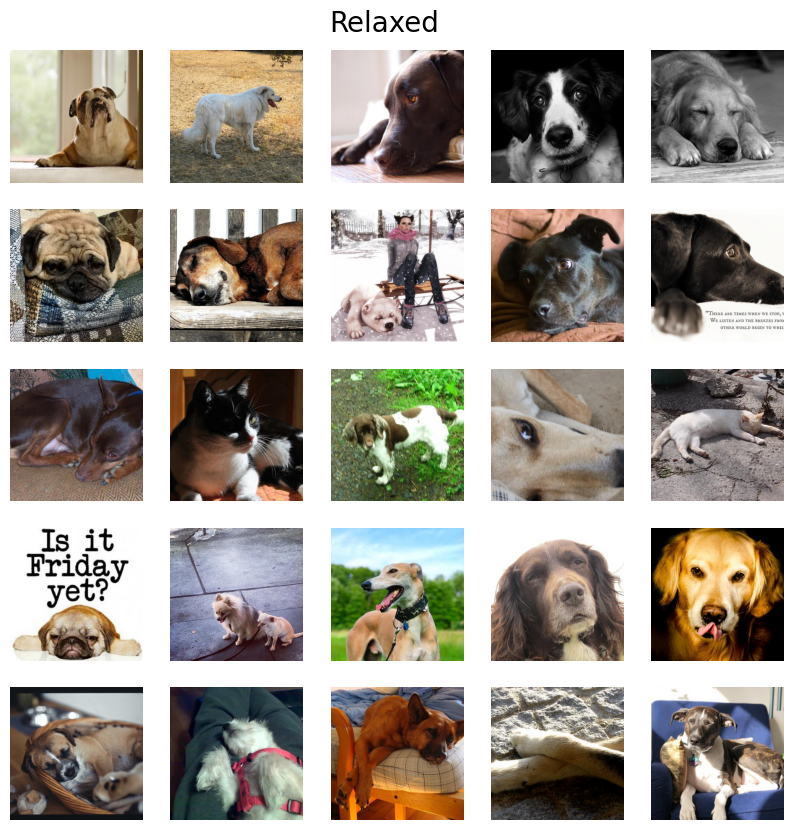

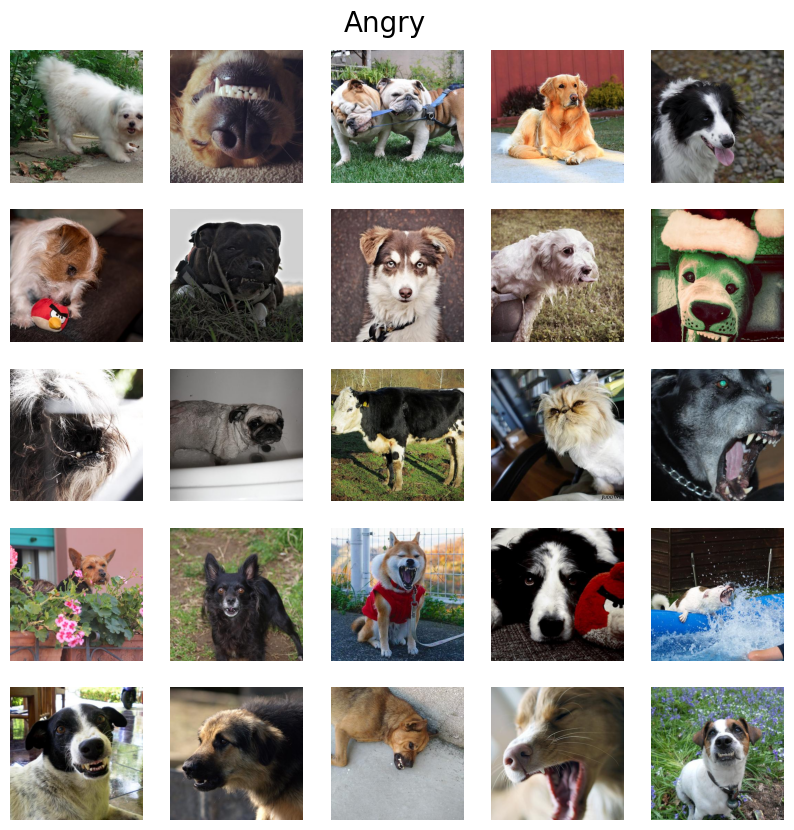

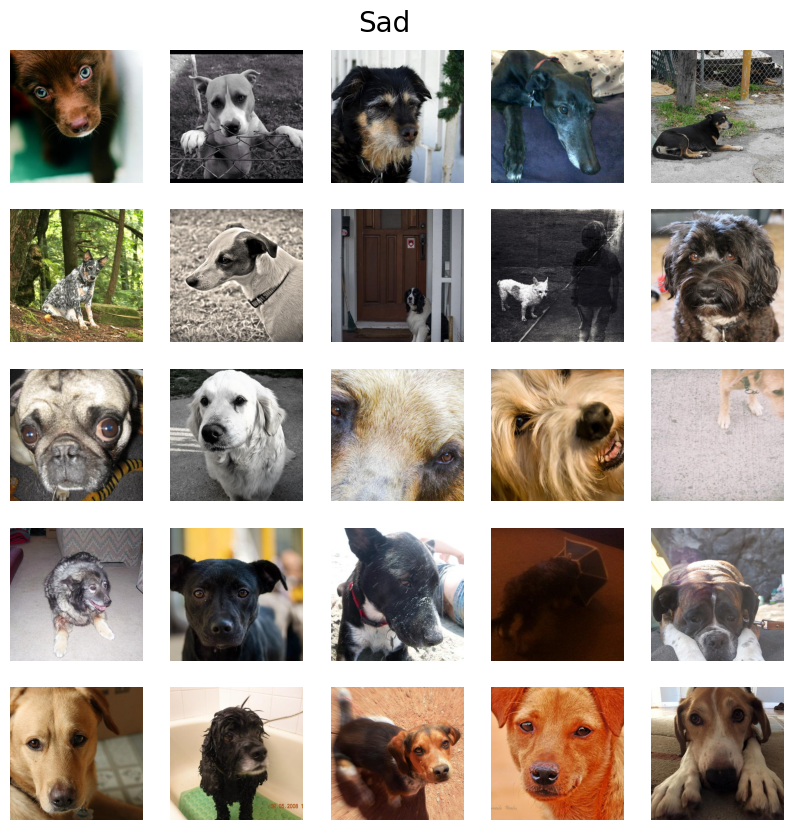

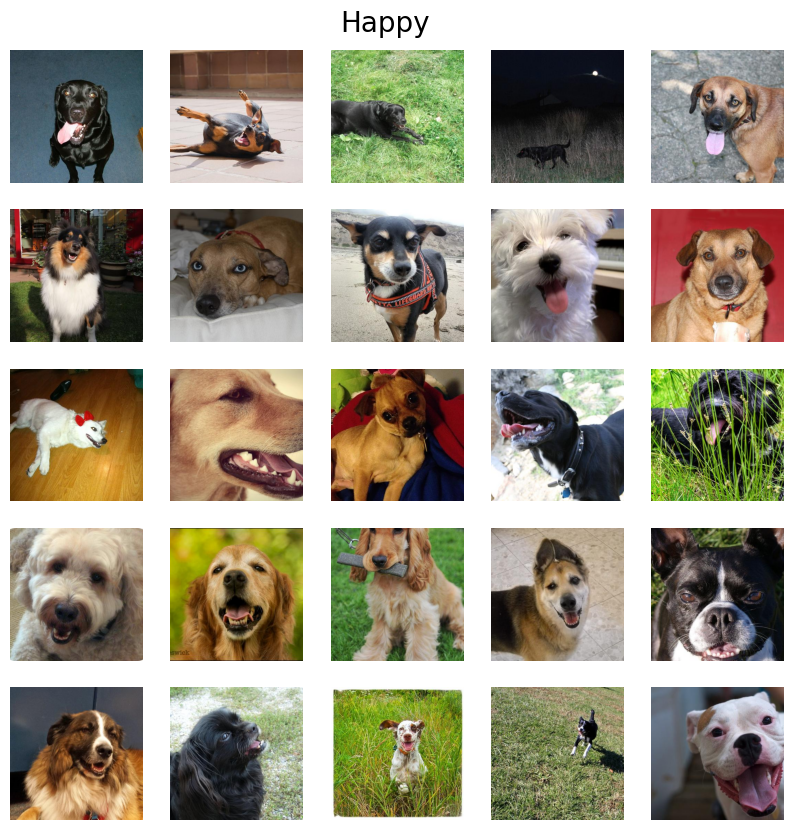

In [ ]:
# 이미지 확인
import matplotlib.pyplot as plt

def plot_image(title, path, images):
  plt.figure(figsize=(10, 10))
  plt.suptitle(title, fontsize = 20, y = 0.92)

  for idx, image in enumerate(images[:25]):
    img = cv2.cvtColor(cv2.imread(path + image), cv2.COLOR_BGR2RGB)
    plt.subplot(5, 5, idx + 1)
    plt.imshow(np.array(img))
    plt.axis('off')

  plt.show()
  print('\n')


plot_image('Relaxed', relaxed_path, relaxed_images)
plot_image('Angry', angry_path, angry_images)
plot_image('Sad', sad_path, sad_images)
plot_image('Happy', happy_path, happy_images)

In [ ]:
"""
데이터셋 구조 변경
------------------
현재 데이터셋 구조:  image/
                        angry/
                        happy/
                        relaxed/
                        sad/
변경 후 데이터셋 구조: image/
                          train/
                              angry/
                              happy/
                              relaxed/
                              sad/
                          val/
                              angry/
                              happy/
                              relaxed/
                              sad/
                          test/
                              angry/
                              happy/
                              relaxed/
                              sad/
"""
# train, val, test 각 8:1:1 비율로 분할하기
splitfolders.ratio(root_path, output='/content/input', seed=77, ratio=(.8, .1, .1))
root_path = '/content/input'  # 변경된 디렉터리의 경로로 root_path를 재할당

Copying files: 15921 files [00:05, 2720.01 files/s]


In [ ]:
# 데이터셋 분할 결과 확인
for class_name in label_map:
  print(f"train/{class_name}: {len(os.listdir(os.path.join(root_path, 'train/' + class_name)))}")
  print(f"val/{class_name}: {len(os.listdir(os.path.join(root_path, 'val/' + class_name)))}")
  print(f"test/{class_name}: {len(os.listdir(os.path.join(root_path, 'test/' + class_name)))}\n")

train/angry: 1804
val/angry: 225
test/angry: 227

train/happy: 3827
val/happy: 478
test/happy: 479

train/relaxed: 3479
val/relaxed: 434
test/relaxed: 436

train/sad: 3625
val/sad: 453
test/sad: 454



In [ ]:
# 구조 변경 전의 데이터셋 삭제
shutil.rmtree('/content/images')

In [ ]:
# Custom Dataset 작성
class DogDataset(Dataset):
  def __init__(self, root_dir, label_map, mode='train', transform=None):  # 데이터셋 전처리
    """
    Parameters
    ----------
    root_dir (str): 데이터셋의 최상위 디렉토리 경로
    label_map (dict): 클래스 라벨을 매핑하는 딕셔너리
    mode (str): train, val, test 중 하나로 데이터셋의 모드를 지정
    transform (callable, optional): 이미지에 적용할 변환 함수
    """
    self.root_dir = root_dir
    self.label_map = label_map
    self.mode = mode
    self.transform = transform
    self.image_paths = []  # 각 이미지의 경로를 저장할 리스트
    self.image_labels = []
    self.classes = sorted(self.label_map.keys())  # 각 이미지의 레이블(정답값)을 저장할 리스트. angry, happy, relaxed, sad

    # 이미지 경로 리스트 초기화
    for class_name in self.classes:
      class_dir = os.path.join(self.root_dir, self.mode, class_name)
      for image_name in os.listdir(class_dir):
        self.image_paths.append(os.path.join(class_dir, image_name))
        if self.mode != 'test':  # test 데이터셋의 경우, 정답 레이블을 저장하지 않음
          self.image_labels.append(self.label_map[class_name])

  def __len__(self):  # 샘플의 수
    return len(self.image_paths)

  def __getitem__(self, idx):  # 인덱스에 해당하는 샘플을 반환
    image = Image.open(self.image_paths[idx]).convert('RGB')
    image = np.array(image)

    if self.transform:
      image = self.transform(image=image)['image']  # 이미지에 변환 함수를 적용

    if self.mode == 'test':
      return image
    else:  # train 또는 val 데이터셋인 경우에만 정답 레이블을 함께 반환
      return image, self.image_labels[idx]

In [ ]:
# albumentations을 이용한 데이터 증강
# 이미지의 크기 조정 -> 이미지 변환 -> 사전 학습된 모델에서 사용된 평균과 표준편차로 정규화 -> 텐서로 변환 수행
# Compose 안에 정의된 모든 변환이 정의된 확률에 따라 순서대로 적용
train_transform = A.Compose([
    A.Resize(224, 224),  # 이미지 크기를 224x224로 조정. VGG16은 224x224 크기의 이미지를 입력받기 때문
    A.HorizontalFlip(p=0.7),  # 좌우 반전 (p는 해당 증강을 입력 데이터에 적용할 확률을 의미)
    A.Rotate(limit=10, p=0.7),  # 회전
    A.RandomBrightnessContrast(p=0.5),  # 밝기와 대비 조정
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.7),  # 일부 영역 무작위로 삭제
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),  # ImageNet 데이터셋에서 계산된 평균값, 표준편차로 정규화 (모델이 사전 학습된 데이터셋의 분포를 따르도록 도움)
    ToTensorV2(),  # 텐서로 변환
])

# validation, test 데이터에 대해서는 증강을 적용하지 않음
val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])
test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [ ]:
# 배치 사이즈, 데이터셋, 데이터로더 정의
batch_size = 32

# 데이터셋 정의
train_dataset = DogDataset(root_dir=root_path, label_map=label_map, mode='train', transform=train_transform)
val_dataset = DogDataset(root_dir=root_path, label_map=label_map, mode='val', transform=val_transform)
test_dataset = DogDataset(root_dir=root_path, label_map=label_map, mode='test', transform=test_transform)

# 데이터로더 정의
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# torchvision 라이브러리를 통해 VGG16 모델을 불러와 활용
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features
model.global_avg_pool2d = torch.nn.AdaptiveAvgPool2d(1)
summary_model(model)

for param in model.parameters():
  param.requires_grad = False  # 역전파 동안 파라미터가 업데이트되지 않도록 함

# Dog emotion image classification task에 맞게 새로운 분류기를 정의
num_classes = 4
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512*1*1, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 167MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [ ]:
# 손실함수 및 스케쥴러, 옵티마이저 설정
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
scheduler = LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 30

for epoch in range(num_epochs):
  print(f'Epoch: {epoch+1}/{num_epochs}')

  # 학습 단계
  model.train()
  train_loss = 0.0  # 한 번의 에폭에서 처리된 모든 미니배치에서 계산된 손실 값을 누적. 평균 손실을 계산하기 위함
  train_correct = 0
  train_total = 0

  for images, labels in tqdm(train_loader, desc='Training'):
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()  # item()으로 손실이 갖고 있는 스칼라값을 얻음
    _, predicted = torch.max(outputs.data, 1)  # 열마다의 최댓값의 위치를 찾아 예측값으로 사용
    train_total += labels.size(0)  # 현재 배치에서의 샘플 수(레이블의 수)를 더함. 이후 전체 데이터셋에 대한 평균 손실, 정확도를 구하는 데 사용하기 위함
    train_correct += (predicted == labels).sum().item()  # 올바르게 예측된 샘플 수를 누적함
  scheduler.step()

  train_loss /= len(train_loader)
  train_accuracy = 100 * train_correct / train_total
  print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

  # 검증 단계
  model.eval()
  val_loss = 0.0
  val_correct = 0
  val_total = 0

  with torch.no_grad():  # 검증 단계에서는 기울기를 계산하지 않음
    for images, labels in tqdm(val_loader, desc="Validating"):
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)

      val_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      val_total += labels.size(0)
      val_correct += (predicted == labels).sum().item()

  val_loss /= len(val_loader)
  val_accuracy = 100 * val_correct / val_total
  print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%\n')

  # 각 에폭의 손실 및 정확도 기록
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accuracies.append(train_accuracy)
  val_accuracies.append(val_accuracy)

Epoch: 1/30


Training: 100%|██████████| 398/398 [01:00<00:00,  6.62it/s]


Train Loss: 1.3692, Train Accuracy: 39.83%


Validating: 100%|██████████| 50/50 [00:08<00:00,  5.89it/s]


Validation Loss: 1.2081, Validation Accuracy: 48.49%

Epoch: 2/30


Training: 100%|██████████| 398/398 [01:00<00:00,  6.59it/s]


Train Loss: 1.2706, Train Accuracy: 43.53%


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.59it/s]


Validation Loss: 1.2040, Validation Accuracy: 50.44%

Epoch: 3/30


Training: 100%|██████████| 398/398 [01:01<00:00,  6.48it/s]


Train Loss: 1.2496, Train Accuracy: 44.70%


Validating: 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]


Validation Loss: 1.2046, Validation Accuracy: 47.92%

Epoch: 4/30


Training: 100%|██████████| 398/398 [01:02<00:00,  6.41it/s]


Train Loss: 1.2497, Train Accuracy: 44.47%


Validating: 100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


Validation Loss: 1.1729, Validation Accuracy: 50.94%

Epoch: 5/30


Training: 100%|██████████| 398/398 [01:02<00:00,  6.34it/s]


Train Loss: 1.2415, Train Accuracy: 44.88%


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.29it/s]


Validation Loss: 1.1885, Validation Accuracy: 50.19%

Epoch: 6/30


Training: 100%|██████████| 398/398 [01:03<00:00,  6.30it/s]


Train Loss: 1.2211, Train Accuracy: 46.24%


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.30it/s]


Validation Loss: 1.1757, Validation Accuracy: 51.70%

Epoch: 7/30


Training: 100%|██████████| 398/398 [01:02<00:00,  6.34it/s]


Train Loss: 1.2352, Train Accuracy: 45.82%


Validating: 100%|██████████| 50/50 [00:08<00:00,  5.94it/s]


Validation Loss: 1.1537, Validation Accuracy: 52.70%

Epoch: 8/30


Training: 100%|██████████| 398/398 [01:02<00:00,  6.36it/s]


Train Loss: 1.2232, Train Accuracy: 46.66%


Validating: 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


Validation Loss: 1.1589, Validation Accuracy: 50.69%

Epoch: 9/30


Training: 100%|██████████| 398/398 [01:02<00:00,  6.33it/s]


Train Loss: 1.2266, Train Accuracy: 45.80%


Validating: 100%|██████████| 50/50 [00:08<00:00,  6.19it/s]


Validation Loss: 1.1424, Validation Accuracy: 50.88%

Epoch: 10/30


Training: 100%|██████████| 398/398 [01:02<00:00,  6.33it/s]


Train Loss: 1.2211, Train Accuracy: 46.38%


Validating: 100%|██████████| 50/50 [00:08<00:00,  6.21it/s]


Validation Loss: 1.1656, Validation Accuracy: 49.50%

Epoch: 11/30


Training: 100%|██████████| 398/398 [01:05<00:00,  6.11it/s]


Train Loss: 1.2129, Train Accuracy: 46.78%


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.26it/s]


Validation Loss: 1.1632, Validation Accuracy: 51.38%

Epoch: 12/30


Training: 100%|██████████| 398/398 [01:03<00:00,  6.29it/s]


Train Loss: 1.2165, Train Accuracy: 46.56%


Validating: 100%|██████████| 50/50 [00:08<00:00,  6.17it/s]


Validation Loss: 1.1624, Validation Accuracy: 51.51%

Epoch: 13/30


Training: 100%|██████████| 398/398 [01:03<00:00,  6.28it/s]


Train Loss: 1.2075, Train Accuracy: 47.79%


Validating: 100%|██████████| 50/50 [00:08<00:00,  5.91it/s]


Validation Loss: 1.1434, Validation Accuracy: 51.01%

Epoch: 14/30


Training: 100%|██████████| 398/398 [01:02<00:00,  6.33it/s]


Train Loss: 1.2087, Train Accuracy: 47.66%


Validating: 100%|██████████| 50/50 [00:08<00:00,  5.99it/s]


Validation Loss: 1.1396, Validation Accuracy: 51.32%

Epoch: 15/30


Training: 100%|██████████| 398/398 [01:02<00:00,  6.35it/s]


Train Loss: 1.2063, Train Accuracy: 47.41%


Validating: 100%|██████████| 50/50 [00:08<00:00,  6.11it/s]


Validation Loss: 1.1472, Validation Accuracy: 52.08%

Epoch: 16/30


Training: 100%|██████████| 398/398 [01:03<00:00,  6.30it/s]


Train Loss: 1.1936, Train Accuracy: 48.15%


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.27it/s]


Validation Loss: 1.1575, Validation Accuracy: 49.87%

Epoch: 17/30


Training: 100%|██████████| 398/398 [01:03<00:00,  6.27it/s]


Train Loss: 1.1970, Train Accuracy: 47.78%


Validating: 100%|██████████| 50/50 [00:08<00:00,  6.12it/s]


Validation Loss: 1.1424, Validation Accuracy: 51.70%

Epoch: 18/30


Training: 100%|██████████| 398/398 [01:02<00:00,  6.32it/s]


Train Loss: 1.1862, Train Accuracy: 48.12%


Validating: 100%|██████████| 50/50 [00:08<00:00,  5.91it/s]


Validation Loss: 1.1167, Validation Accuracy: 53.96%

Epoch: 19/30


Training: 100%|██████████| 398/398 [01:02<00:00,  6.33it/s]


Train Loss: 1.1813, Train Accuracy: 48.34%


Validating: 100%|██████████| 50/50 [00:08<00:00,  6.10it/s]


Validation Loss: 1.1350, Validation Accuracy: 52.33%

Epoch: 20/30


Training: 100%|██████████| 398/398 [01:02<00:00,  6.34it/s]


Train Loss: 1.1804, Train Accuracy: 48.66%


Validating: 100%|██████████| 50/50 [00:08<00:00,  6.21it/s]


Validation Loss: 1.1264, Validation Accuracy: 52.52%

Epoch: 21/30


Training: 100%|██████████| 398/398 [01:03<00:00,  6.32it/s]


Train Loss: 1.1866, Train Accuracy: 48.73%


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.26it/s]


Validation Loss: 1.1196, Validation Accuracy: 51.45%

Epoch: 22/30


Training: 100%|██████████| 398/398 [01:03<00:00,  6.25it/s]


Train Loss: 1.1748, Train Accuracy: 49.43%


Validating: 100%|██████████| 50/50 [00:08<00:00,  6.24it/s]


Validation Loss: 1.1370, Validation Accuracy: 51.19%

Epoch: 23/30


Training: 100%|██████████| 398/398 [01:02<00:00,  6.35it/s]


Train Loss: 1.1734, Train Accuracy: 49.23%


Validating: 100%|██████████| 50/50 [00:08<00:00,  5.86it/s]


Validation Loss: 1.1207, Validation Accuracy: 52.89%

Epoch: 24/30


Training: 100%|██████████| 398/398 [01:03<00:00,  6.32it/s]


Train Loss: 1.1636, Train Accuracy: 49.52%


Validating: 100%|██████████| 50/50 [00:08<00:00,  5.96it/s]


Validation Loss: 1.1206, Validation Accuracy: 52.52%

Epoch: 25/30


Training: 100%|██████████| 398/398 [01:02<00:00,  6.33it/s]


Train Loss: 1.1607, Train Accuracy: 50.26%


Validating: 100%|██████████| 50/50 [00:08<00:00,  6.20it/s]


Validation Loss: 1.1234, Validation Accuracy: 51.82%

Epoch: 26/30


Training: 100%|██████████| 398/398 [01:02<00:00,  6.33it/s]


Train Loss: 1.1591, Train Accuracy: 49.70%


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.31it/s]


Validation Loss: 1.1189, Validation Accuracy: 51.82%

Epoch: 27/30


Training: 100%|██████████| 398/398 [01:03<00:00,  6.25it/s]


Train Loss: 1.1543, Train Accuracy: 50.22%


Validating: 100%|██████████| 50/50 [00:08<00:00,  6.09it/s]


Validation Loss: 1.1116, Validation Accuracy: 51.76%

Epoch: 28/30


Training: 100%|██████████| 398/398 [01:02<00:00,  6.33it/s]


Train Loss: 1.1505, Train Accuracy: 50.11%


Validating: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Validation Loss: 1.1156, Validation Accuracy: 52.01%

Epoch: 29/30


Training: 100%|██████████| 398/398 [01:02<00:00,  6.33it/s]


Train Loss: 1.1533, Train Accuracy: 49.45%


Validating: 100%|██████████| 50/50 [00:08<00:00,  6.11it/s]


Validation Loss: 1.1233, Validation Accuracy: 50.75%

Epoch: 30/30


Training: 100%|██████████| 398/398 [01:02<00:00,  6.33it/s]


Train Loss: 1.1544, Train Accuracy: 50.04%


Validating: 100%|██████████| 50/50 [00:08<00:00,  6.17it/s]

Validation Loss: 1.1222, Validation Accuracy: 52.01%



In [ ]:
# 테스트 단계

correct = 0
total = 0

with torch.no_grad():
  for images in test_loader:
    images = images.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 41.92%


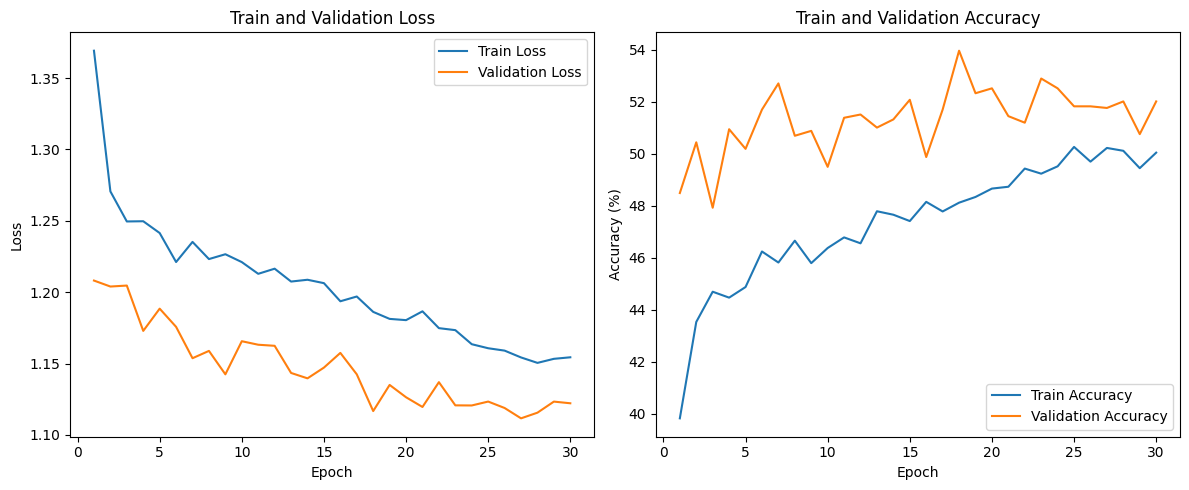

In [ ]:
# 손실 그래프
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()